In [1]:
import os
from itertools import product

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from consts import *
from scipy.special import logit
from scipy.stats import ttest_rel
from statannotations.stats.StatTest import StatTest
from utils import (
    FilteredAnnotator,
    model_test_pairs,
    process_mutation_dataset,
    task2muts,
)

plt.style.use("mike.mplstyle")

In [2]:
import glob

paths = sorted(glob.glob("../concept/*/*"))

In [3]:
def process_full_concept_paths(files):
    data = []
    for path in files:
        parts = path.split("/")
        stem = parts[-2]
        model, prot, task = stem.split("_")
        fold = parts[-1]
        ds = "Full"
        row_info = {"fold": fold, "model": model, "prot": prot, "task": task, "DS": ds}

        effect_muts, neutral_muts = task2muts(task)
        dataset = datasets.load_from_disk(path)

        data.append(process_mutation_dataset(dataset, effect_muts, [], loss_only=False))
        for key, val in row_info.items():
            data[-1][key] = val

    return pd.concat(data, axis=0, ignore_index=True)


concept_df = process_full_concept_paths(paths).replace(
    {"task": TASK_FANCY_NAMES, "model": MODEL_FANCY_NAMES}
)
skip_mask = concept_df["metric"].str.startswith("neutral")
concept_df.head()

,index,field,value,metric,fold,model,prot,task,DS
0,0,FPV,1.0,WT,0,Null-Model,PR,Protease\nResistance,Full
1,1,FPV,1.0,WT,0,Null-Model,PR,Protease\nResistance,Full
2,2,FPV,1.0,WT,0,Null-Model,PR,Protease\nResistance,Full
3,3,FPV,0.0,WT,0,Null-Model,PR,Protease\nResistance,Full
4,4,FPV,1.0,WT,0,Null-Model,PR,Protease\nResistance,Full


In [4]:
prob_ticks = [1 / 100, 1 / 10, 1 / 2, 9 / 10, 99 / 100]
ticks = logit(prob_ticks)

fields = CORECEPTOR_ORDER
colors = dict(zip(CORECEPTOR_ORDER, sns.color_palette(CORECEPTOR_CMAP)))


def plot_model_coreceptor_mutations(df, ax, alpha=0.1, s=10):

    wt_preds = df.query('metric == "WT"').groupby(["fold", "index"])["value"].first()
    for metric, mdf in df.groupby("metric"):
        mut_vals = mdf.groupby(["fold", "index"])["value"].first()
        x, y = wt_preds.align(mut_vals)

        if metric.startswith("functional-gain"):  # X4 promoting
            ax.scatter(x=logit(x), y=logit(y), color=colors["CXCR4"], alpha=alpha, s=s)
        elif metric.startswith("functional-loss"):  # R5 promoting
            ax.scatter(x=logit(x), y=logit(y), color=colors["CCR5"], alpha=alpha, s=s)

In [5]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

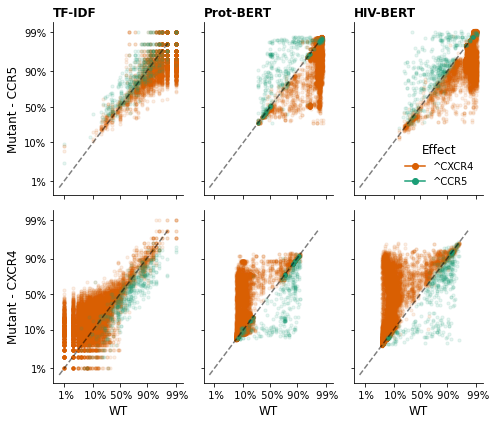

In [6]:
corecept_concepts = concept_df.query('task == "Coreceptor"')

fig, axs = plt.subplots(
    len(fields), 3, figsize=HALF_PAGE_FIGSIZE, sharex=True, sharey=True
)

for col, model in enumerate(MODEL_FANCY_ORDER[1:]):
    model_mask = corecept_concepts["model"] == model
    for row, field in enumerate(fields):
        ax = axs[row, col]
        field_mask = corecept_concepts["field"] == field
        ndf = corecept_concepts.loc[field_mask & model_mask]
        plot_model_coreceptor_mutations(ndf, ax)
        ax.plot(
            np.arange(-5, 5), np.arange(-5, 5), color="k", linestyle="--", alpha=0.5
        )
        ax.legend([], [], frameon=False)

        if ax.get_subplotspec().is_first_row():
            ax.set_title(model)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(f"WT")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"Mutant - {field}")

        if (row == 0) & (col == 2):
            legend_elements = [
                Line2D([0], [0], marker="o", color=colors["CXCR4"], label="^CXCR4"),
                Line2D([0], [0], marker="o", color=colors["CCR5"], label="^CCR5"),
            ]

            ax.legend(handles=legend_elements, title="Effect")

        ax.set_xticks(ticks)
        ax.set_xticklabels([f" {100*p:0.0f}%" for p in prob_ticks])
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{100*p:0.0f}%" for p in prob_ticks])

        sns.despine(ax=ax)

fig.tight_layout()

In [7]:
try:
    fig.savefig(str(snakemake.output["coreceptor_effect"]), dpi=300)
except NameError:
    fig.savefig("Fig6-coreceptor_mutation_effect-high.png", dpi=300)

In [8]:
fields = DRUG_ORDER
colors = dict(zip(DRUG_ORDER, sns.color_palette(DRUG_CMAP)))


def plot_model_resistance_mutations(df, ax, field, alpha=0.1, s=10):

    wt_preds = df.query('metric == "WT"').groupby(["fold", "index"])["value"].first()
    for metric, mdf in df.groupby("metric"):
        mut_vals = mdf.groupby(["fold", "index"])["value"].first()
        x, y = wt_preds.align(mut_vals)

        if metric.startswith("functional-gain"):  # X4 promoting
            ax.scatter(x=logit(x), y=logit(y), color="r", alpha=alpha, s=s)
        elif metric.startswith("functional-loss"):  # R5 promoting
            ax.scatter(x=logit(x), y=logit(y), color="gray", alpha=alpha, s=s)

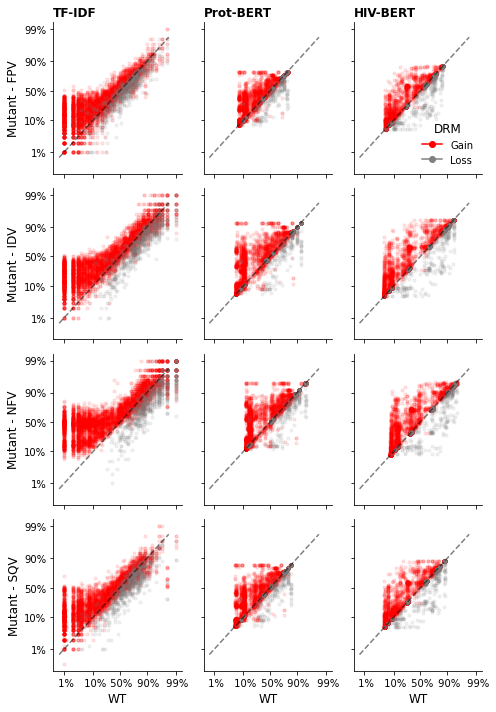

In [9]:
fig, axs = plt.subplots(
    len(fields), 3, figsize=FULL_PAGE_FIGSIZE, sharex=True, sharey=True
)
drug_concepts = concept_df.loc[concept_df["task"] == "Protease\nResistance"]
for col, model in enumerate(MODEL_FANCY_ORDER[1:]):
    model_mask = drug_concepts["model"] == model
    for row, field in enumerate(fields):
        ax = axs[row, col]
        field_mask = drug_concepts["field"] == field
        ndf = drug_concepts.loc[field_mask & model_mask]
        plot_model_resistance_mutations(ndf, ax, field)
        ax.plot(
            np.arange(-5, 5), np.arange(-5, 5), color="k", linestyle="--", alpha=0.5
        )
        ax.legend([], [], frameon=False)

        if ax.get_subplotspec().is_first_row():
            ax.set_title(model)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(f"WT")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"Mutant - {field}")

        if (row == 0) & (col == 2):
            legend_elements = [
                Line2D([0], [0], marker="o", color="red", label="Gain"),
                Line2D([0], [0], marker="o", color="gray", label="Loss"),
            ]

            ax.legend(handles=legend_elements, title="DRM")

        ax.set_xticks(ticks)
        ax.set_xticklabels([f" {100*p:0.0f}%" for p in prob_ticks])
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{100*p:0.0f}%" for p in prob_ticks])

        sns.despine(ax=ax)

fig.tight_layout()

In [10]:
try:
    fig.savefig(str(snakemake.output["resistance_effect"]), dpi=300)
except NameError:
    fig.savefig("Fig8-resistance_mutation_effect-high.png", dpi=300)

In [11]:
pd.pivot_table(
    concept_df.query('metric == "concept_loss"'),
    index=["task", "field"],
    columns="model",
    values="value",
    aggfunc="mean",
)

model                       HIV-BERT  Null-Model  Prot-BERT     TF-IDF
task                 field                                            
Coreceptor           CCR5   0.715613   79.929212   0.654880  25.403206
                     CXCR4  0.001173  183.885093   0.004608   0.342387
Protease\nResistance FPV    0.000481  189.199787   0.007355   0.690568
                     IDV    0.000727  198.604159   0.015482   0.160683
                     NFV    0.000945  206.390574   0.014119   0.543497
                     SQV    0.000460  203.660273   0.009612   0.211249

In [12]:
def grouped_loss_ax(loss_df):
    common_args = dict(
        data=loss_df, hue="model", hue_order=MODEL_FANCY_ORDER, x="task", y="value"
    )
    pairs = model_test_pairs(TASK_FANCY_ORDER[:-1], transpose=False)
    return common_args, pairs


def coreceptor_loss_ax(loss_df):
    common_args = dict(
        data=loss_df.query('task == "Coreceptor"'),
        hue="model",
        hue_order=MODEL_FANCY_ORDER,
        x="field",
        y="value",
    )
    pairs = model_test_pairs(CORECEPTOR_ORDER, transpose=False)
    return common_args, pairs


def pr_loss_ax(loss_df):

    common_args = dict(
        data=loss_df.loc[loss_df["task"] == "Protease\nResistance"],
        hue="model",
        hue_order=MODEL_FANCY_ORDER,
        x="field",
        y="value",
    )
    pairs = model_test_pairs(DRUG_ORDER, transpose=False)
    return common_args, pairs

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Coreceptor_Null-Model vs. Coreceptor_TF-IDF: Paired T-test with Bonferroni correction, P_val:4.706e-03 Stat=5.476e+00
Protease
Resistance_Null-Model vs. Protease
Resistance_TF-IDF: Paired T-test with Bonferroni correction, P_val:5.093e-21 Stat=5.293e+01
Protease
Resistance_TF-IDF vs. Protease
Resistance_Prot-BERT: Paired T-test with Bonferroni correction, P_val:1.239e-03 Stat=4.883e+00
Protease
Resistance_TF-IDF vs. Protease
Resistance_HIV-BERT: Paired T-test with Bonferroni correction, P_val:8.285e-04 Stat=5.063e+00
Coreceptor_Null-Model vs. Coreceptor_Prot-BERT: Paired T-test with Bonferroni correction, P_val:4.800e-04 Stat=7.424e+00
Protease
Resistance_Null-Model vs. Protease
Resistance_Prot-BERT: Paired T-test with Bonferroni correction, P_val:4.244e-21 Stat=5.345e+01
Protease
Resistance_Null-Model vs. P

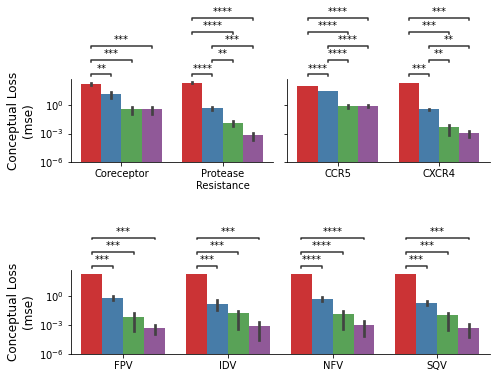

In [13]:
from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator

stat_test = StatTest(ttest_rel, "Paired T-test", "paired")

loss_df = concept_df.query('metric == "concept_loss"')
loss_df = loss_df.groupby(["task", "field", "fold", "model"], as_index=False)[
    "value"
].mean()

order = [grouped_loss_ax, coreceptor_loss_ax, pr_loss_ax]

with sns.color_palette(MODEL_CMAP):
    fig, axs = plt.subplots(2, 2, figsize=HALF_PAGE_FIGSIZE, sharey=True)
    gp_ax, co_ax = axs[0, 0], axs[0, 1]
    pr_ax = plt.subplot(212)

    axs = [gp_ax, co_ax, pr_ax]

    for ax, func in zip(axs, order):
        ax.set_yscale("log")
        kwargs, _ = func(loss_df)
        sns.barplot(ax=ax, **kwargs)
        ax.legend([], [], frameon=False)
        sns.despine(ax=ax)
        ax.set_ylim(1e-6, 500)
        ax.set_xlabel("")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(f"Conceptual Loss\n(mse)")
        else:
            ax.set_ylabel("")

    for ax, func in zip(axs, order):
        kwargs, pairs = func(loss_df)
        annotator = FilteredAnnotator(ax, pairs, **kwargs)
        annotator.configure(
            test=stat_test,
            text_format="star",
            loc="outside",
            comparisons_correction="bonf",
        )
        annotator.apply_and_annotate()


fig.tight_layout()

In [14]:
try:
    fig.savefig(str(snakemake.output["conceptual_model_results"]), dpi=300)
except NameError:
    fig.savefig("Fig9-conceptual_model_results-high.png", dpi=300)